# CAPSTONE PROJECT

by Joyce Ooi

Problem Statement:

There is difficulty in selecting stocks with consistent ROI due to market volatility. We want to identify stocks that allow us to predict consistent returns and which might also allow portfolio diversification, by identifying stocks that correlate to each other or correlate to economic indicators.

We want to be able to predict whether stocks in this portfolio will generate positive or negative returns and adjust our stock selection accordingly.

We were faced with 2 optional paradigms:

Approach 1: Auto regression, ie. using previous timepoints as predictors of outcome and as features (e.g. previous days MA price and use each of those to predict future values. 

Approach 2: News sentiment / twitter sentiment, other types of regression analysis

The aim of this project is to build a predictive model that would predict whether Tesla Stock would close up or down for a given day based on the information on the opening and closing prices of each day as well as the movements in regional indexes, news related to Tesla stock as well as Twitter feeds by its CEO Elon Musk.

Part 1 : At the initial ideas stage we identified 2 groups of stocks to investigate and predict before settling on Tesla. The two options were <br> 
1) FANNG stocks versus Cloud stocks (Co-relation with each other and co-relation to variables such as previous day percentage changes in DJI, current percentage changes in regional indexes (CAC, DAX) and news headlines related to eack stock) <br>2) Any 2 stocks exhibiting a positive or negative co-relation

Part 2 is an initial analysis and cleaning of the csv files. It is also the first checkpoint with EDA. Sentiment analysis was performed separately on all portfolio stocks based on online news articles such as Yahoo. News headlines for all stocks was taken from: https://ycharts.com/companies/news

Part 3 is the selection process whereby we narrowed our selection down to Tesla to make predictions. Tesla was selected due to the frequency of Elon Musk's Twitter feeds and and strong following which we felt could have impact on Tesla's share price. Tesla's headline sentiments also showed a higher correlation to opening change and percent (pct) change compared to Facebook, Amazon or Google. Tesla stock also showed little correlation to the other FAANG stocks which made it suitable for portfolio diversification.

Part 4 is the modelling process, where we selected a series of models to find the best Classifier. These included:
- Logistic Regression
- KNeighboursClassifier
- AdaboostClassifier
- DecisionTree Classifier
- RandomForestClassfier
- ExtraTreesClassifier

Part 5 is the conclusion of our project with the process from start to finish outlining all the steps taken, and the presentation and analysis of the predictive model /models Notebook.

A KNN model was able to predict Tesla's share priced to X% (baseline of X%).

## Notebook 4: Modelling

This notebook contains the code for model selection and evaluation.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Data Preparation](#Data-Preparation)
- [Baseline Accuracy](#Baseline-Accuracy)
- [Randomised Search for the Best Classifier](#Randomised-Search-for-the-Best-Classifier)
- [Selection of the Best Classifier](#Selection-of-the-Best-Classifier)
- [Further Exploration of the Best Classifier](#Further-Exploration-of-the-Best-Classifier)
    * [xx](#Logistic-Regression-Coefficient)
    * [xxxx](#ROC---AUC-Curve)
- [xxxx](#Cost-Benefit-Analysis)
    * [xxx](#Quantitative-Cost-Factors)
    * [xxx](#Qualitative-Cost-Factors)
    * [xx](#Quantitative-Benefit-Factors)
    * [xxx](#Qualitative-Benefit-Factors)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [Generation of Predictions](#Generation-of-Predictions)
- [Data Export](#Data-Export)



## Importing of Libraries

In [1]:
# Read in libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from mpl_toolkits import mplot3d
from sklearn import ensemble, preprocessing
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.preprocessing.sequence import TimeseriesGenerator

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%matplotlib inline 

Using TensorFlow backend.


In [2]:
# Import data from downloaded csv files
train=pd.read_csv('./datasets/tsla_train.csv')
test_actual=pd.read_csv('./datasets/tsla_test.csv')


In [3]:
train.shape, test_actual.shape

((1970, 50), (466, 50))

In [4]:
train.head()

,Unnamed: 0,date,tsla_intra_target,tsla_sentiment,em_tweets3_sentiment,dax_return,cac_return,dji_previous_day_return,MA5,MA10,...,em_tweets3_sentiment_lag3,dax_return_lag3,cac_return_lag3,dji_previous_day_return_lag3,MA5_lag3,MA10_lag3,MA20_lag3,MA50_lag3,change_lag3,volatity_lag3
0,30,2010-08-12,1.0,0.0,0.0,-1.0,1.0,-1.0,18.490,19.168,...,0.0,1.0,1.0,-1.0,19.986,19.824,19.7955,19.6968,0.000510,0.041525
1,31,2010-08-13,0.0,0.0,0.0,-1.0,-1.0,-1.0,18.326,18.919,...,0.0,-1.0,-1.0,1.0,19.314,19.662,19.6860,19.6720,-0.029513,0.041491
2,32,2010-08-16,0.0,0.0,0.0,-1.0,-1.0,-1.0,18.350,18.753,...,0.0,-1.0,-1.0,-1.0,18.744,19.448,19.6450,19.7104,-0.061216,0.041826
3,33,2010-08-17,0.0,0.0,0.0,1.0,1.0,-1.0,18.524,18.704,...,0.0,-1.0,1.0,-1.0,18.490,19.168,19.5775,19.8278,-0.016902,0.042109
4,34,2010-08-18,1.0,0.0,0.0,1.0,-1.0,1.0,18.762,18.757,...,0.0,-1.0,-1.0,-1.0,18.326,18.919,19.5365,19.9306,0.040094,0.036775


In [5]:
test_actual.head()

,Unnamed: 0,date,tsla_intra_target,tsla_sentiment,em_tweets3_sentiment,dax_return,cac_return,dji_previous_day_return,MA5,MA10,...,em_tweets3_sentiment_lag3,dax_return_lag3,cac_return_lag3,dji_previous_day_return_lag3,MA5_lag3,MA10_lag3,MA20_lag3,MA50_lag3,change_lag3,volatity_lag3
0,2000,2018-06-11,0.0,1.0,-1.0,1.0,1.0,1.0,325.623999,321.031000,...,-1.0,1.0,-1.0,-1.0,303.056000,302.525003,309.739502,312.464601,0.092987,0.021095
1,2001,2018-06-12,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,330.679999,327.666000,...,1.0,-1.0,-1.0,1.0,308.223999,308.426001,313.142502,312.965801,-0.010730,0.028782
2,2002,2018-06-13,1.0,1.0,1.0,1.0,-1.0,-1.0,339.006000,335.075000,...,1.0,1.0,1.0,1.0,315.296002,313.732001,317.503001,313.301601,0.004955,0.028909
3,2003,2018-06-14,0.0,-1.0,-1.0,1.0,1.0,-1.0,347.108002,341.216998,...,-1.0,1.0,1.0,1.0,325.623999,321.031000,320.925001,313.656001,0.044455,0.028744
4,2004,2018-06-15,0.0,0.0,1.0,-1.0,-1.0,-1.0,354.853998,345.488998,...,-1.0,-1.0,-1.0,-1.0,330.679999,327.666000,323.714001,314.169001,0.031623,0.030147


## Data Preparation

In [6]:
train = train.drop(['Unnamed: 0'], axis = 1)
test_actual = test_actual.drop(['Unnamed: 0'], axis = 1)

In [7]:
train.head()

,date,tsla_intra_target,tsla_sentiment,em_tweets3_sentiment,dax_return,cac_return,dji_previous_day_return,MA5,MA10,MA20,...,em_tweets3_sentiment_lag3,dax_return_lag3,cac_return_lag3,dji_previous_day_return_lag3,MA5_lag3,MA10_lag3,MA20_lag3,MA50_lag3,change_lag3,volatity_lag3
0,2010-08-12,1.0,0.0,0.0,-1.0,1.0,-1.0,18.490,19.168,19.5775,...,0.0,1.0,1.0,-1.0,19.986,19.824,19.7955,19.6968,0.000510,0.041525
1,2010-08-13,0.0,0.0,0.0,-1.0,-1.0,-1.0,18.326,18.919,19.5365,...,0.0,-1.0,-1.0,1.0,19.314,19.662,19.6860,19.6720,-0.029513,0.041491
2,2010-08-16,0.0,0.0,0.0,-1.0,-1.0,-1.0,18.350,18.753,19.5065,...,0.0,-1.0,-1.0,-1.0,18.744,19.448,19.6450,19.7104,-0.061216,0.041826
3,2010-08-17,0.0,0.0,0.0,1.0,1.0,-1.0,18.524,18.704,19.4945,...,0.0,-1.0,1.0,-1.0,18.490,19.168,19.5775,19.8278,-0.016902,0.042109
4,2010-08-18,1.0,0.0,0.0,1.0,-1.0,1.0,18.762,18.757,19.4420,...,0.0,-1.0,-1.0,-1.0,18.326,18.919,19.5365,19.9306,0.040094,0.036775


In [8]:
test_actual.head()

,date,tsla_intra_target,tsla_sentiment,em_tweets3_sentiment,dax_return,cac_return,dji_previous_day_return,MA5,MA10,MA20,...,em_tweets3_sentiment_lag3,dax_return_lag3,cac_return_lag3,dji_previous_day_return_lag3,MA5_lag3,MA10_lag3,MA20_lag3,MA50_lag3,change_lag3,volatity_lag3
0,2018-06-11,0.0,1.0,-1.0,1.0,1.0,1.0,325.623999,321.031000,320.925001,...,-1.0,1.0,-1.0,-1.0,303.056000,302.525003,309.739502,312.464601,0.092987,0.021095
1,2018-06-12,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,330.679999,327.666000,323.714001,...,1.0,-1.0,-1.0,1.0,308.223999,308.426001,313.142502,312.965801,-0.010730,0.028782
2,2018-06-13,1.0,1.0,1.0,1.0,-1.0,-1.0,339.006000,335.075000,326.422002,...,1.0,1.0,1.0,1.0,315.296002,313.732001,317.503001,313.301601,0.004955,0.028909
3,2018-06-14,0.0,-1.0,-1.0,1.0,1.0,-1.0,347.108002,341.216998,329.334001,...,-1.0,1.0,1.0,1.0,325.623999,321.031000,320.925001,313.656001,0.044455,0.028744
4,2018-06-15,0.0,0.0,1.0,-1.0,-1.0,-1.0,354.853998,345.488998,331.973001,...,-1.0,-1.0,-1.0,-1.0,330.679999,327.666000,323.714001,314.169001,0.031623,0.030147


In [9]:
train.isnull().sum()

date                            0
tsla_intra_target               0
tsla_sentiment                  0
em_tweets3_sentiment            0
dax_return                      0
cac_return                      0
dji_previous_day_return         0
MA5                             0
MA10                            0
MA20                            0
MA50                            0
change                          0
volatility                      0
tsla_intra_target_lag1          0
tsla_sentiment_lag1             0
em_tweets3_sentiment_lag1       0
dax_return_lag1                 0
cac_return_lag1                 0
dji_previous_day_return_lag1    0
MA5_lag1                        0
MA10_lag1                       0
MA20_lag1                       0
MA50_lag1                       0
change_lag1                     0
volatity_lag1                   0
tsla_intra_target_lag2          0
tsla_sentiment_lag2             0
em_tweets3_sentiment_lag2       0
dax_return_lag2                 0
cac_return_lag

In [10]:
train['date']=pd.to_datetime(train['date'])

In [11]:
test_actual['date']=pd.to_datetime(test_actual['date'])

train.shape, test_actual.shape

In [12]:
# X and Y variable
X = train.drop(columns = ['tsla_intra_target', 'date']) 
y = train['tsla_intra_target']


In [13]:
X_testuntrain = test_actual.drop(columns = ['tsla_intra_target','date']) 
y_testuntrain = test_actual['tsla_intra_target']

In [14]:
#Train Test split 
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [15]:
#X_test = test.drop(['    '], axis=1)

## Baseline Accuracy

In [16]:
y_train.value_counts(normalize = True)

1.0    0.508463
0.0    0.491537
Name: tsla_intra_target, dtype: float64

We observe above that the baseline accuracy (for predicting an intraday positive return for Tesla stock) is approximately 51.18%. The naive model will predict all 1s and will be correct 51.18% of the time.

## Balanced Class

The baseline accuracy above indicates that the **training set is balanced** 

As this is a classification problem, we foresee that our methods should perform relatively well given roughly equal-sized class.

## Randomised Search for the Best Classifier

To manage the total time and resources used to tune the hyperparameters, we use the RandomizedSearchCV to randomly find the optimal parameters for each of the models based on the training dataset, with a maximum of 50 iterations. We specify the range of parameters to be used by RandomizedSearchCV for each classifer, based on experience and past results of running the RandomizedSearchCV.

We obtain the AUC score on the validation dataset for each classifier using the optimal parameters identified by RandomizedSearchCV. We will select the best classifier based on the **highest AUC score** found.

In [17]:
# We fit a StandardScaler() object on just the training dataset,
# then use the object to transform both the training and validation datasets

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train) #fit with X train data and use it to transform both X_train and X_valid data
X_valid_sc = ss.transform(X_valid)

X_testuntrain_sc = ss.transform(X_testuntrain) #use the same fit above with X train data on the untrained (test_actual) data set


In [18]:
# We have selected the models below for modelling purposes.
estimators = {
    'lr': LogisticRegression(random_state=42),
    'knn': KNeighborsClassifier(),
    'ada': AdaBoostClassifier(random_state=42),
    'dtree': DecisionTreeClassifier(random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'etree': ExtraTreesClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42)
}.items()

In [98]:
params = {
    'lr': {
        'lr__solver': ['liblinear'],
        'lr__penalty': ['l1', 'l2', 'elasticnet'],
        'lr__C': np.logspace(1, 5, 20)
    },
    
    'knn': {
        'knn__n_neighbors': [3, 5, 7, 9],
        'weights':['uniform','distance'],
        'algorithm':['ball_tree','kd_tree','brute','auto'],
        'leaf__size':range(1,152),
        'metric':['euclidean','manhatten','minkowski']
 },
    'ada': {
        'ada__n_estimators': [500, 1000, 1500, 2000],
        'ada__learning_rate': [1, 1.5, 2]
    },
    'dtree': {
        'dtree__max_depth': [ 10 ,15, 25, 50],
        'dtree__max_features': ['auto', 'log2', None, 50, 100],
        'dtree__min_samples_split': [5, 10, 20, 30],
        'dtree__min_samples_leaf': [2, 3, 4, 5]
    },
     'rf': {
         'rf__max_depth': [1000, 2000, 3000, 4000],
         'rf__max_features': ['auto', 'log2', None, 50],
         'rf__min_samples_split': [2, 4, 6],
         'rf__min_samples_leaf': [1, 3, 5]
     },
     'etree': {
         'etree__max_depth': [40, 50, 60, 70],
         'etree__max_features': ['auto', 'log2', None, 50],
         'etree__min_samples_split': [2, 4, 6],
         'etree__min_samples_leaf': [1, 2, 3]
     },
    
    
'xgb' : {
    'xgb__learning_rate': [1, 1.5,2],
    'xgb__n_estimators': [200,300, 400, 500],
    'xgb__min_samples_leaf': [1, 2, 3],
    'xgb__max_depth': [3,5,7,9,10],
    'xgb__min_child_weight':[1],
    'xgb__gamma': [0,1,2,3],
    'xgb__subsample':[0.6, 0.8, 1],
    'xgb__colsample_bytree':[0.5, 0.7, 0.8,1],
    'xgb__nthread':[-1,1,2,3,4],
    'xgb__scale_pos_weight':[1]  
},
    
    
}



We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best mean accuracy score based on the training dataset.

In [99]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
train_accuracy = []
val_accuracy = []
best_score = []
train_roc_auc = []
val_roc_auc = []
sensitivity = []
specificity = []

for k,v in estimators:
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter=50, # we set a max. of 50 iterations
        estimator=pipe,
        random_state=42,
        param_distributions=param,
        verbose=1,
        cv= 5,
        n_jobs=-1,
        return_train_score= True,
        scoring = 'roc_auc' # we adopt AUC score as our scoring metric as it is provides the best overall assessment
    )

    randomsearch.fit(X_train_sc, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_pred_train = model.predict(X_train_sc)
    y_pred_valid = model.predict(X_valid_sc)
    
    # print results
    print ("Model: ", k)
    print ("Best parameters:", best_params)
    print ("Best AUC cross validation score:", randomsearch.best_score_)
    print ("Training dataset accuracy:", accuracy_score(y_train,y_pred_train))
    print ("Validation dataset accuracy:", accuracy_score(y_valid,y_pred_valid))
    print ("Training dataset AUC score:", roc_auc_score(y_train,y_pred_train))
    print ("Validation dataset AUC score:", roc_auc_score(y_valid,y_pred_valid))
    # obtain true positive and false negatives to calculate sensitivity
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_valid).ravel() 
    print ("Validation dataset sensitivity", tp/(tp+fn))
    print ("Validation dataset specificity", tn/(tn+fp))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_accuracy.append(accuracy_score(y_train,y_pred_train))
    val_accuracy.append(accuracy_score(y_valid,y_pred_valid))
    train_roc_auc.append(roc_auc_score(y_train,y_pred_train))
    val_roc_auc.append(roc_auc_score(y_valid,y_pred_valid))
    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 243 out of 250 | elapsed:  5.0min remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model:  lr
Best parameters: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': 10.0}
Best AUC cross validation score: 0.905221099456622
Training dataset accuracy: 0.8469871360866622
Validation dataset accuracy: 0.8235294117647058
Training dataset AUC score: 0.8467598757212607
Validation dataset AUC score: 0.8232112870830727
Validation dataset sensitivity 0.8406374501992032
Validation dataset specificity 0.8057851239669421

Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: Invalid parameter weights for estimator Pipeline(memory=None,
         steps=[('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

## Selection of the Best Classifier

In [100]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best AUC cross validation score': best_score,
    'Training dataset accuracy': train_accuracy,
    'Validation dataset accuracy': val_accuracy,
    'Training dataset AUC score': train_roc_auc,
    'Validation dataset AUC score': val_roc_auc,
    'Validation dataset sensitivity': sensitivity,
    'Validation dataset specificity': specificity
    })

pd.set_option('display.max_colwidth', -1)
summary.sort_values('Validation dataset AUC score', ascending=False).reset_index(drop=True)

/Users/joyceooi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,model,parameters,Best AUC cross validation score,Training dataset accuracy,Validation dataset accuracy,Training dataset AUC score,Validation dataset AUC score,Validation dataset sensitivity,Validation dataset specificity
0,lr,"{'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': 10.0}",0.905221,0.846987,0.823529,0.84676,0.823211,0.840637,0.805785


The table above shows the performance of the various models in terms of their optimal parameters, and the different metrics used to evaluate the models, namely accuracy, AUC scores and sensitivity. The classifiers are sorted based on descending order of the sensitivity score on the validation dataset.

We choose the **xxxxxx** (xx) classifier as our best classifier, given that it has the highest AUC score on the validation dataset (xxx). Although it did not achieve an accuracy (xxx%) higher than the baseline accuracy of 0.515443% , this is still a much model because the baseline model will also never predict xxxx. Besides, we observe minimal overfitting of the model when comparing both the accuracy and AUC scores of the training and validation datasets.

Besides having the highest ROC-AUC score, the Logistic Regression model has the highest sensitivity (0.651), which is an important metric in this case. False negatives need to be reduced so that mosquito control measures can be done at all areas which have the virus.

## Further exploration of the Best Classifier

### Logistic Regression Coefficients

In [22]:
# We instantiate the logistic regression classifier based on the best parameters found above
#lr_best = LogisticRegression(random_state=42, solver='liblinear', penalty='l1', C=1274.2749857031336)

In [23]:
# Fit the logistic regression classifier on the scaled training dataset
#lr_best.fit(X_train_sc, y_train)

In [24]:
# Generate a plot of the logistic regression coefficients
# The coefficients are exponentiated to reverse the effect of logistic regression
# fig = plt.figure(figsize=(10,5))
# feature_scores = pd.DataFrame(np.exp(lr_best.coef_), columns=X.columns)
# feature_scores.loc[0,:].sort_values(ascending=True).plot(kind='barh');
# plt.xlabel("Logistic Regression Coefficient")
# plt.ylabel("Feature")
# plt.title("Effect of feature on Tesla Share Price");

**Findings:**



The coefficient which is most significant is 
 
Thus, we can infer that 

The second most significant interaction term is 

We can infer that 

### ROC-AUC Curve

In [25]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validation set.
# 2. The list of predicted probabilities based on our model.

# pred_proba = [i[1] for i in lr_best.predict_proba(X_valid_sc)]

# pred_df = pd.DataFrame({'true_values': y_valid,
#                         'pred_probs':pred_proba})
# pred_df.head()

# KNN

In [26]:
knn=KNeighborsClassifier(n_neighbors=9)

In [27]:
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [28]:
knn_pred = pd.DataFrame(knn.predict(X_testuntrain_sc), columns=['tsla_intra_target'])


In [29]:
#Concatenate the predictions  with the X_testuntrain dataframe
test_pred= pd.concat([X_testuntrain,knn_pred], axis=1)


In [30]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, knn_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall

In [31]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.6137339055793991
Precision:0.575107296137339
Recall:0.6232558139534884
F1 Score:0.5982142857142857


# RF

In [32]:
rf=RandomForestClassifier(random_state=42, min_samples_split=4, min_samples_leaf=1, max_features='log2',max_depth=3000 )

In [33]:
rf.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3000, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
rf_pred = pd.DataFrame(rf.predict(X_testuntrain_sc), columns=['tsla_intra_target'])


In [35]:
#Concatenate the predictions  with the X_testuntrain dataframe
test_pred= pd.concat([X_testuntrain,rf_pred], axis=1)

In [36]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, rf_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall

In [37]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.778969957081545
Precision:0.7666666666666667
Recall:0.7488372093023256
F1 Score:0.7576470588235295


# ADA


In [38]:
ada=AdaBoostClassifier(random_state=42, n_estimators=1500, learning_rate=1.5)

In [39]:
ada.fit(X_train_sc, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.5,
                   n_estimators=1500, random_state=42)

In [40]:
ada_pred = pd.DataFrame(ada.predict(X_testuntrain_sc), columns=['tsla_intra_target'])


In [41]:
#Concatenate the predictions  with the X_testuntrain dataframe
test_pred= pd.concat([X_testuntrain,ada_pred], axis=1)

In [42]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, ada_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall


In [43]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.7188841201716738
Precision:0.6653543307086615
Recall:0.786046511627907
F1 Score:0.7206823027718551


# DTREE

In [44]:
dtree= DecisionTreeClassifier(random_state=42)

In [45]:
dtree.fit(X_train_sc, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [46]:
dtree_pred = pd.DataFrame(dtree.predict(X_testuntrain_sc), columns=['tsla_intra_target'])

In [47]:
#Concatenate the predictions  with the X_testuntrain dataframe
test_pred= pd.concat([X_testuntrain,dtree_pred], axis=1)




In [48]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, dtree_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall


In [49]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.7081545064377682
Precision:0.6889952153110048
Recall:0.6697674418604651
F1 Score:0.6792452830188679


# ETREE

In [50]:
etree= ExtraTreesClassifier(random_state=42, min_samples_split=4,min_samples_leaf=1,max_features='log2',max_depth=60)

In [51]:
etree.fit(X_train_sc, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=60, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [52]:
etree_pred = pd.DataFrame(etree.predict(X_testuntrain_sc), columns=['tsla_intra_target'])

In [53]:
#Concatenate the predictions  with the X_testuntrain dataframe
test_pred= pd.concat([X_testuntrain,etree_pred], axis=1)



In [54]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, etree_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall


In [55]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.6931330472103004
Precision:0.6714285714285714
Recall:0.6558139534883721
F1 Score:0.6635294117647059


# LR

In [56]:
lr =LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=42)

In [57]:
lr.fit(X_train_sc, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
lr_pred = pd.DataFrame(lr.predict(X_testuntrain_sc), columns=['tsla_intra_target'])

In [59]:
#Concatenate the predictions  with the X_testuntrain dataframe
test_pred= pd.concat([X_testuntrain,lr_pred], axis=1)

test_pred['tsla_intra_target'].value_counts(normalize=True)


1.0    0.538627
0.0    0.461373
Name: tsla_intra_target, dtype: float64

In [60]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, lr_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall


In [61]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.7682403433476395
Precision:0.7131474103585658
Recall:0.8325581395348837
F1 Score:0.7682403433476396


In [88]:
xgb = XGBClassifier(random_state=42, subsample=1, scale_pos_weight= 1, 
                    nthread= 1, n_estimators=500, min_child_weight=1, 
                    max_depth=10, learning_rate=1.5, gamma=0, colsample_bytree=0.5)

In [89]:
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=1.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [90]:
xgb_pred = pd.DataFrame(xgb.predict(X_testuntrain_sc), columns=['tsla_intra_target'])

In [91]:
test_pred= pd.concat([X_testuntrain,xgb_pred], axis=1)

test_pred['tsla_intra_target'].value_counts(normalize=True)


0.0    0.525751
1.0    0.474249
Name: tsla_intra_target, dtype: float64

In [92]:
tn, fp, fn, tp = confusion_matrix(y_testuntrain, xgb_pred).ravel() 
precision=tp/(tp+fp)
recall=tp/(tp+fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
F1=(precision*recall)/precision+recall


In [93]:
print ("Accuracy:{}".format(accuracy)),
print ("Precision:{}".format(precision)),
print ("Recall:{}".format(recall)),
print ("F1 Score:{}".format(2*((precision*recall)/(precision+recall))))

Accuracy:0.7682403433476395
Precision:0.7420814479638009
Recall:0.7627906976744186
F1 Score:0.7522935779816514


# Further Exploration of Best Classifier

In [82]:
pred_proba=[i[1] for i in rf.predict_proba(X_testuntrain_sc)]

In [83]:
pred_df=pd.DataFrame ({'true_values':y_testuntrain,
                      'pred_probs': pred_proba})

In [84]:
pred_df.head(100)

,true_values,pred_probs
0,0.0,0.328333
1,1.0,0.265833
2,1.0,0.288333
3,0.0,0.265333
4,0.0,0.439500
...,...,...
95,1.0,0.624833
96,1.0,0.329750
97,0.0,0.416833
98,1.0,0.385083


In [85]:
X_testuntrain_sc

array([[ 1.70624306, -1.97796366,  0.98897555, ...,  1.36256433,
         2.93770012, -0.76474267],
       [-1.66515627, -1.97796366, -1.02998352, ...,  1.36710486,
        -0.39263083, -0.05826711],
       [ 1.70624306,  1.38970473,  0.98897555, ...,  1.37014697,
         0.11100717, -0.04660212],
       ...,
       [ 0.02054339,  1.38970473, -1.02998352, ..., -1.46815011,
         0.15086078,  5.87506291],
       [ 0.02054339,  1.38970473, -1.02998352, ..., -1.46815011,
         1.33515418,  5.77103772],
       [ 0.02054339,  1.38970473, -1.02998352, ..., -1.46815011,
         4.04740039,  5.82848113]])

# AUC Scores on Unseen Test Data

In [94]:

print('AUC Score for KNN: {}'.format(roc_auc_score(y_testuntrain,knn_pred)))
print('AUC Score for RF: {}'.format(roc_auc_score(y_testuntrain,rf_pred)))
print('AUC Score for ADA: {}'.format(roc_auc_score(y_testuntrain,ada_pred)))
print('AUC Score for DTREE: {}'.format(roc_auc_score(y_testuntrain,dtree_pred)))
print('AUC Score for ETREE: {}'.format(roc_auc_score(y_testuntrain,etree_pred)))
print('AUC Score for LR: {}'.format(roc_auc_score(y_testuntrain,lr_pred)))
print('AUC Score for XGB: {}'.format(roc_auc_score(y_testuntrain,xgb_pred)))

AUC Score for KNN: 0.6144167515982581
AUC Score for RF: 0.7768090428981748
AUC Score for ADA: 0.7237005466506069
AUC Score for DTREE: 0.7054016492170851
AUC Score for ETREE: 0.6904567775409988
AUC Score for LR: 0.7728527749467248
AUC Score for XGB: 0.7678495321041415


|                  ||AUC Score|
|------------------||---------------------|
|KNN:||0.5498824152893246|
|RF:||0.5071792918419397|
|ADA:|| 0.5559603855453612|
|DTREE:|| 0.4734357921234805|
|ETREE:|| 0.5217448908615151|
|LR:||0.5547265741446126|

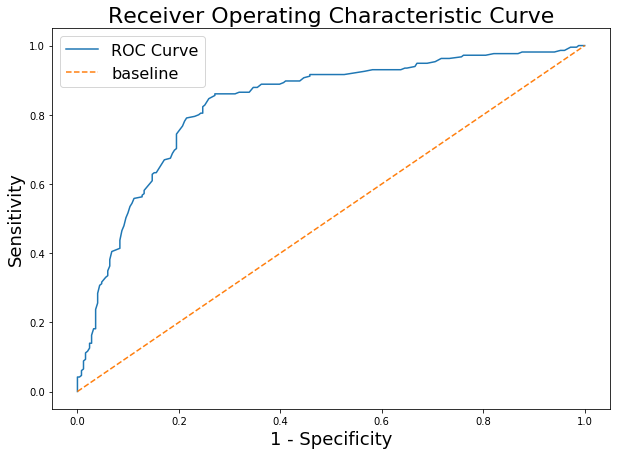

In [87]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

**Interpreting ROC AUC**

ROC is a probability curve and AUC represents the degree of separability i.e. the capability of the model in distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. 

If AUC is 1, the positive (Tesla Stock Price = 1) and negative populations (Tesla Stock Price = 0) are perfectly separated. Here, we have an AUC of 0.

---
## Conclusions and Recommendations

### A. Our Classifier

We have trained a classifier to predict when and where wheter Tesla share price will increase or decrease. Our classifier is xxx which gives a rather high sensitivity/specificity rate of xxx% .

**Limitations**

1. The limitation of this model lies in the use of time-series data which could mean that the data is autocorrelated. This can lead to implications on the computation of standard errors.
2. More data is required for more accurate analysis. Earlier EDA revealed 

**Areas for further investigation**

We have yet to explore the variable of xxxx A 

This variable could have 

However, as this variable is not present in the test set, we dropped it from our training dataset. In future analysis, we could 

### B. xxxx

Based on our observations, 

**Focus on Sensitivity/Specificity**

The sensitivity of our model to predict whether Tesla Stock price goes up or down is xxx%. (we can tune parameters to get different results)

We view sensitivity/specificity as a priority as  less serious issue.

**A xxxx Approach**



**A xxx Approach**




## Generation of Predictions

In [74]:
# Generate the predictions based on the scaled testing dataset
y_pred = pd.DataFrame(lr_best.predict(X_test_sc), columns=['tsla_intra_target'])

NameError: name 'lr_best' is not defined

In [ ]:
# Concatenate the predictions with the X_test dataframe
test_pred = pd.concat([X_test, y_pred], axis=1)

In [ ]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test_pred, test['id']], axis=1)

In [ ]:
# Verify that we have a mix of predictions for tsla_intra_target
test_pred['tsla_intra_target'].value_counts()

## Data Export

In [ ]:
test_pred.to_csv("../assets/test_pred.csv", index=False)